## Introduction

In this project we will use a Kaggle dataset, comprised of 10,000 tweets via Twitter to build a natural language processing model that is able to classify whether a tweet is related to a real disaster. 

We shall utilize the Tensorflow package and Keras API, to build a neural network model that will be able to do this task as well as do initial exploratory data analysis

In [1]:
import tensorflow as tf 
import tensorflow_addons as tfa
!pip install -q -U keras-tuner 
!pip install scikeras
!pip install seaborn
!pip install wordcloud
!pip install transformers
!pip install nltk
!pip install -U spacy
!python -m spacy download en_core_web_sm
import keras_tuner as kt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten, Bidirectional, BatchNormalization, TimeDistributed
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
import nltk 
nltk.download('stopwords') 
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures
from wordcloud import WordCloud
import unicodedata
from transformers import TFBertModel, BertPreTrainedModel, BertTokenizer
import os
import tempfile
!pip install text_hammer
import text_hammer as th
from collections import Counter
tf.random.set_seed(1234)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 70.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.0 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.3 MB/s eta 0:00:00
 

In [2]:
train_data = pd.read_csv('/kaggle/input/train-data/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('/kaggle/input/test-data/test.csv',usecols=['id','text'])
sample_data = pd.read_csv('/kaggle/input/sample-data/sample_submission.csv')
print(tf.__version__)


2.11.0


In [3]:
train_data.head()
train_target  = train_data.target.values
print(train_data.value_counts())

id     text                                                                                                                                       target
1      Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                      1         1
7229   We have overrun a Natural Disaster Survival server!                                                                                        1         1
7250   Nuclear deal disaster.\n\n#IranDeal #NoNuclearIran #BadIranDeal @JebBush @BarackObama http://t.co/z7phPjtqud                               0         1
7248   Alarming Rise in Dead Marine Life Since the #Fukushima Nuclear Disaster: http://t.co/v6H97K688J http://t.co/tJw9bSeiPW                     1         1
7247   beforeitsnews : 3 former executives to be prosecuted in Fukushima nuclear disaster Û_ http://t.co/FgVN2vCrrX) http://t.co/kftVNU7nvf      1         1
                                                         

In [4]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis

We see that our data contains symbols, stop words and irregular contractions. We shall need to clean and standardize our data for tokenization and vectorization. This will help to remove redundancy and the need for high dimensionality of our word embeddings. 

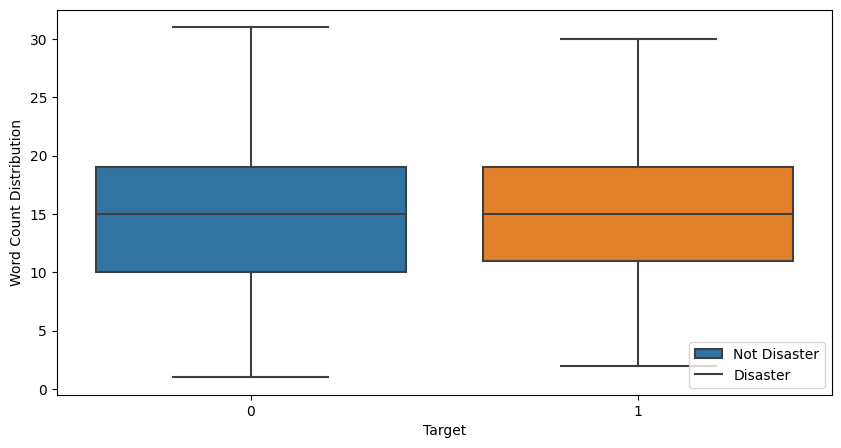

In [5]:
plt.figure(figsize=(10,5))
train_length = train_data['text'].str.split().apply(lambda x : len(x))
sns.boxplot(x=train_data['target'],y=train_length,data=train_data)
plt.xlabel("Target")
plt.ylabel("Word Count Distribution")
plt.legend(['Not Disaster', 'Disaster'], loc ="lower right" )
plt.show()

While the median word counts between  disaster and non-disaster related tweets do not show much varitaion, we see that the word count for non-disaster related tweets have a greater interquartile range and variability than disaster related tweets.

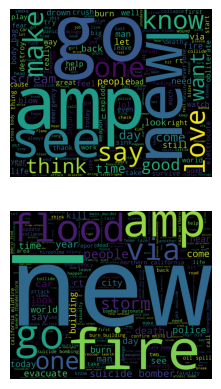

<Figure size 2000x2000 with 0 Axes>

In [6]:
contraction_map = {
    "can't": "cannot",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "it's": "it is",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "that's": "that is"
}

def contractions(text):
    remove_contractions = re.compile(r"\b(can't|won't|wouldn't|shouldn't|it's|you're|he's|she's|they're|we're|that's)\b")
    return remove_contractions.sub(lambda x: contraction_map[x.group(0)], text)

def emails(text): 
    remove_emails = re.compile(r'\S+@\S+') 
    return remove_emails.sub('', text)

def htmls(text): 
    remove_htmls = re.compile(r'<[^>]+>|https?://\S+')
    return remove_htmls.sub('', text)

def accents(text): 
    remove_accents = re.compile(r'[^\w\s]+')
    return remove_accents.sub('', unicodedata.normalize('NFKD', text))

def punctuations(text): 
    remove_punctuations = re.compile(r'[^\w\s]+')
    return remove_punctuations.sub('', text)


def clean(df, column): 
    df[column] = df[column].str.lower()
    df[column] = df[column].apply(lambda x : contractions(x))
    df[column] = df[column].apply(lambda x : emails(x))
    df[column] = df[column].apply(lambda x : htmls(x))
    df[column] = df[column].apply(lambda x : punctuations(x))
    df[column] = df[column].apply(lambda x : accents(x))
    df[column] = df[column].apply(lambda x: th.make_base(x))
    
    return df

train_data = clean(train_data, 'text')

stop_words = set(stopwords.words('english'))

def remove_stopwords(df, column): 
    df[column] = df[column].apply(lambda x : ' '.join([word for word in x.split() if word not in stop_words]))
    return df 

train_data = remove_stopwords(train_data, 'text')

def generate_wordcloud(df, n) : 
    all_tweets = df[df['target'] == n]
    word_string = []
    for t in all_tweets.text:
        word_string.append(t)
    word_string = pd.Series(word_string).str.cat(sep=' ')
    return word_string 

non_disaster_wordcloud = generate_wordcloud(train_data, 0)
disaster_wordcloud = generate_wordcloud(train_data, 1)
wordcloud_0 = WordCloud(width=2400, height=2000).generate(non_disaster_wordcloud)
wordcloud_1 = WordCloud(width=2400, height=2000).generate(disaster_wordcloud)
fig,axes = plt.subplots(2,1)
plt.figure(figsize=(20,20))
axes[0].imshow(wordcloud_0)
axes[1].imshow(wordcloud_1)
axes[0].axis('off')
axes[1].axis('off')
plt.show()

We plot 2 wordclouds, for the composition of unique words for disaster and non-disaster related tweets after text preprocessing. While we see that a majority of words used in non-disaster are largely general (new, make, go, see, one) we see several words that could also be associated also with disasters such as "fire", "burn", "drown" and "injury". This shows that contextual understanding is important as such words can be cause misinterpretations. 

We can infer that disasters involving fires, floods, involving violence, mass evacuations, suicide bombers and mainly located in northern california are the most common based on the wordcloud for disaster related tweets.

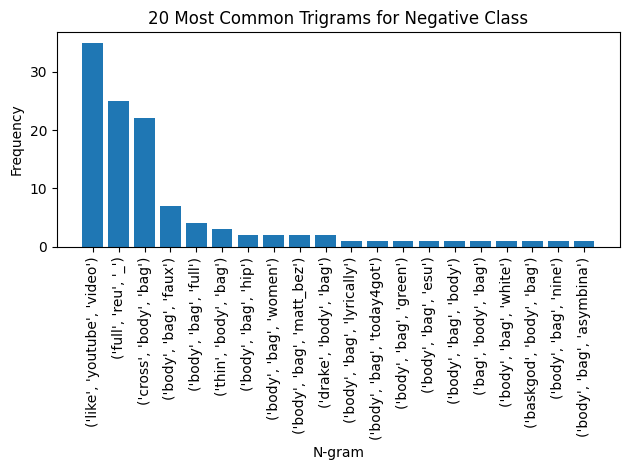

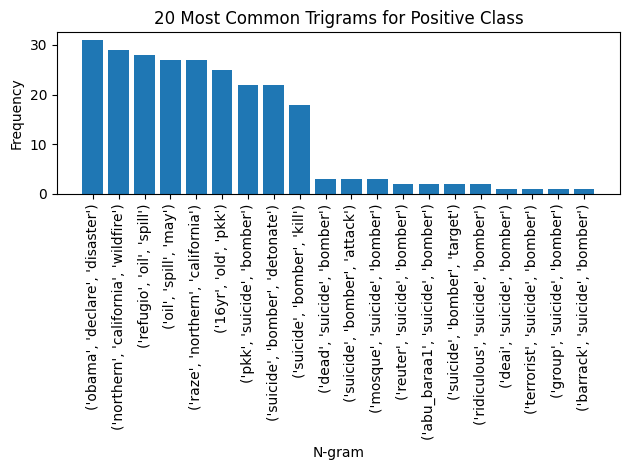

In [7]:
def plot_most_common_trigrams(corpus, num_common, target):
    tokens = nltk.word_tokenize(corpus)
    ngram_finder = TrigramCollocationFinder.from_words(tokens)
    most_common_ngrams = ngram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, num_common)
    ngrams_counts = zip(*[(ngram, freq) for ngram, freq in ngram_finder.ngram_fd.items() if ngram in most_common_ngrams])
    ngrams_counts = list(ngrams_counts)
    ngrams = ngrams_counts[0]
    counts = ngrams_counts[1]
    ngrams_list = []
    for i in ngrams: 
        text = ' '.join(i)
        ngrams_list.append(text)
    if target == 1 : 
        binary_class = 'Positive'
    else : 
        binary_class = 'Negative'
    df = pd.DataFrame({'ngrams' : ngrams_list, 'counts' : counts})
    df_sorted = df.sort_values('counts', ascending=False)
    plt.bar('ngrams', 'counts', width=0.8, data = df_sorted)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.title(f'{num_common} Most Common Trigrams for {binary_class} Class')
    plt.xticks(range(len(ngrams)), ngrams, rotation='vertical')
    plt.tight_layout()
    plt.show()
    
corpus_train = ' '.join(train_data[train_data['target']==0]['text'])
plot_most_common_trigrams(corpus_train, 20, 0)
corpus_train = ' '.join(train_data[train_data['target']==1]['text'])
plot_most_common_trigrams(corpus_train, 20, 1)

Trigrams are 3 consecutive words, and we see that the most common trigrams for non-disaster related tweets involve youtube videos and body bags. 

Trigrams for disaster related tweets are less homogenous, we see that "obama declare disaster" is the most common trigram. Tweets involving wildfires in northern california, oil spills and suicide bomber attacks are common based off the trigrams, this supports the earlier inference from our wordcloud regarding the most commonly tweeted types of disasters.

In [8]:
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = train_data["text"]

counter = counter_word(text_values)
vocab_size = len(counter)
print(vocab_size)

15644


In [9]:
train_text = train_data['text']
train_target = train_data['target']
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_text)

train_text = tokenizer.texts_to_sequences(train_text)
train_text = pad_sequences(train_text, maxlen=36, padding='post', truncating='post')
print(train_text)

[[3808  450  208 ...    0    0    0]
 [ 142    4  189 ...    0    0    0]
 [1478  503 1812 ...    0    0    0]
 ...
 [2825 3802 5648 ...    0    0    0]
 [  31  804 2702 ...    0    0    0]
 [ 132   35  392 ...    0    0    0]]


We shall use the Tokenizer from Keras Preprocessing to tokenize our text data, and pad our sequences to set the maximum length at 36. 

## Hyperparameter Optimization

In [10]:
f1_score = tfa.metrics.F1Score(1, average='macro', threshold = 0.5)
def build_model(hp):
    input_ids = Input(shape=(36,), dtype=tf.int32, name="input_ids")
    hp_learning_rate = hp.Choice('learning_rate',values = [0.01, 0.001, 0.005])
    hp_beta_1 = hp.Choice('beta_1',values = [0.95, 0.99])
    hp_beta_2 = hp.Choice('beta_2',values = [0.95, 0.99])
    hp_epsilon = hp.Choice('epsilon',values = [1e-8, 1e-7, 1e-6])
    embeddings = Embedding(vocab_size, output_dim = 32,input_length = 36)(input_ids)
    out = Bidirectional(LSTM(units=64, dropout=0.5, return_sequences=True))(embeddings)
    out = BatchNormalization()(out)
    out = TimeDistributed(Dense(16,activation = 'relu'))(out)
    out = BatchNormalization()(out)
    out = TimeDistributed(Dense(1,activation = 'sigmoid'))(out)
    y = out[:, -1, :] 
    model = tf.keras.Model(inputs=input_ids, outputs=y)
    optimizer = tf.keras.optimizers.Adam(lr = hp_learning_rate, beta_1 = hp_beta_1, beta_2 = hp_beta_2, epsilon = hp_epsilon)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=f1_score)

    return model



A recurrent neural network is a network that sequentially processes data, by using non-linear activaton functions for transforming weighted combination of the inputs at each time step and previous hidden states (which is also derived from earlier inputs). This makes it suitable for text classification, by being able to sequentially pass through vector representations of each tokenized word in a text at each time step. 

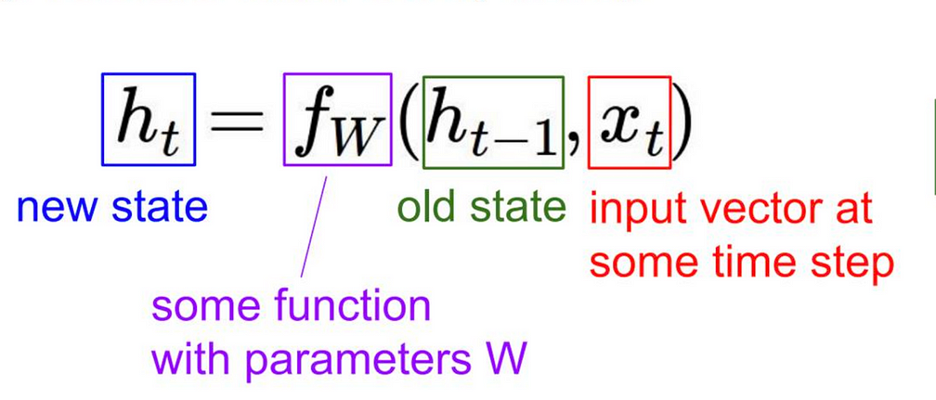

We shall define a function, that will build a functional Tensorflow Neural Network utilizing an LSTM layer and a Dense Layer. We utilize LSTM, in order to address the problem of vanishing gradients which occur when weights of the layer are less than 1. Simple recurrent neural networks have difficulty capturing long-term dependencies in text due to this, LSTM is able to retain both long-term and short-term information. We will include an array of potential parameter choices for the learning rate, beta 1, beta 2 and epsilon. These are parameters of the Adam optimizer which we will be using. 

We will add 2 dense layers after the LSTM layer, one with 16 neurons to extract information on a broader level from the final sequence output of the LSTM layer. The last Dense layer is given a sigmoid activation function and a single neuron to tranform our output to lie between 0 to 1 for classification.

After each Dense layer and LSTM layer, we add in a layer for performing Batch Normalization. This will help to normalize the values of the outputs of neuron activations. This addresses the problem of the distribution of neuron activation outputs changing over time as the network is trained and weights are updated, this may also cause a vanishing gradient and slow convergence. Normalizing the activation outputs of a neural network with multiple layers will solve this. 

We will use the Adam optimizer, which uses different learning rates per parameter based on past gradients and sqaured gradients. This will also help the model converge faster even in the midst of sparse gradients, which is when the gradients of multiple parameters in a model are 0. This often occurs when text is represented in high dimensional vectors. We will pass in an array of potential values for each hyperparameter in the Adam optimizer which we will tune using Keras Tuner. 

The primary objective of this functional model is to find the optimal hyperparamters we will use to build our model, fit our training data on and ultimately classify our test data. 

In [11]:
tuner = kt.RandomSearch(build_model,
                     objective='val_loss',
                     max_trials=144,
                     directory='random2',
                     project_name='my_project_kaggle10')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
tuner.search(x = train_text, y=train_target, epochs=7, validation_split=0.2, callbacks=[stop_early] ,batch_size = 128)
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps.values)

Trial 34 Complete [00h 00m 18s]
val_loss: 0.691301703453064

Best val_loss So Far: 0.4712830185890198
Total elapsed time: 00h 16m 02s
{'learning_rate': 0.01, 'beta_1': 0.99, 'beta_2': 0.95, 'epsilon': 1e-07}


We optimize for the validation loss, and also track the F1 score which combines the precision and recall score of the model to provide a balanced measure of a model's performance in binary classification tasks. 

The Adam optimizer utilizes the following formula to update each parameter :

**new_parameter = old_parameter - (learning_rate * moving average of gradients) / (sqrt(moving average of squared gradients) + epsilon)**

The learning rate specified is the initial global learning rate that the Adam optimizer will utilize for each parameter when it starts training, beta 1 and beta 2 define the exponential decay rates for the moving average value and the variance of the gradients respectively. They are weights applied to the current and past gradient statistics for the learning rate to adjust to. Utilizing the moving average and variance of the partial derivative of the loss function with respect to each parameter in the network for the learning rate to adapt to, allows for more stabilized convergence. The epsilon parameter is a constant value to ensure that values are not divided by zero. 




In [12]:
input_ids = Input(shape=(36,), dtype=tf.int32, name="input_ids")
embeddings = Embedding(vocab_size, output_dim = 32,input_length = 36)(input_ids)
out = Bidirectional(LSTM(units=64, dropout=0.5,return_sequences=True))(embeddings)
out = BatchNormalization()(out)
out = TimeDistributed(Dense(16,activation = 'relu'))(out)
out = BatchNormalization()(out)
out = TimeDistributed(Dense(1,activation = 'sigmoid'))(out)
y = out[:, -1, :] 
model = tf.keras.Model(inputs=input_ids, outputs=y)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 36)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 36, 32)            500608    
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 128)          49664     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 36, 128)          512       
 hNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, 36, 16)           2064      
 tributed)                                                       
                                                           

## Model Diagnostics

We have now constructed a functional model with our optimal hyperparameters. We will now fit the training data onto the model with these hyperparameters and see its performance on a validation split.

In [13]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(
    learning_rate=0.001,
    beta_1 = 0.99,
    beta_2 = 0.99,
    epsilon = 1e-06), loss = tf.keras.losses.BinaryCrossentropy(), metrics=f1_score)
final = model.fit(x =train_text, epochs = 7, batch_size=128, validation_split=0.2, y=train_target)

Epoch 1/7
48/48 [==============================] - 5s 31ms/step - loss: 0.7233 - f1_score: 0.2015 - val_loss: 0.6907 - val_f1_score: 0.0000e+00
Epoch 2/7
48/48 [==============================] - 1s 12ms/step - loss: 0.6811 - f1_score: 0.0077 - val_loss: 0.6927 - val_f1_score: 0.0000e+00
Epoch 3/7
48/48 [==============================] - 1s 12ms/step - loss: 0.6754 - f1_score: 0.0078 - val_loss: 0.6915 - val_f1_score: 0.0000e+00
Epoch 4/7
48/48 [==============================] - 1s 12ms/step - loss: 0.6182 - f1_score: 0.4187 - val_loss: 0.6349 - val_f1_score: 0.6646
Epoch 5/7
48/48 [==============================] - 1s 12ms/step - loss: 0.4146 - f1_score: 0.7946 - val_loss: 0.5410 - val_f1_score: 0.7172
Epoch 6/7
48/48 [==============================] - 1s 12ms/step - loss: 0.3183 - f1_score: 0.8398 - val_loss: 0.4748 - val_f1_score: 0.7691
Epoch 7/7
48/48 [==============================] - 1s 12ms/step - loss: 0.2484 - f1_score: 0.8796 - val_loss: 0.4861 - val_f1_score: 0.7677


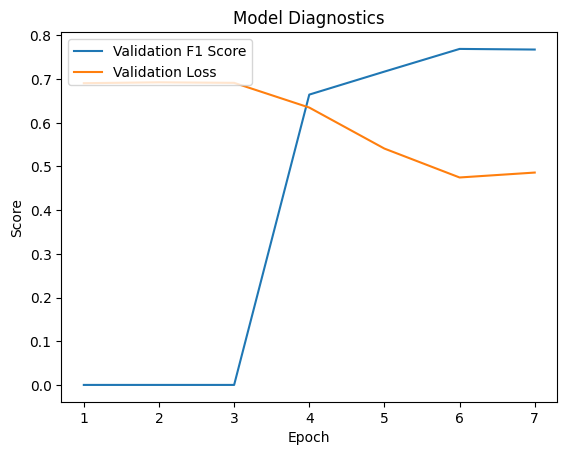

In [14]:
plt.plot(np.arange(1, len(model.history.history['val_f1_score']) + 1), model.history.history['val_f1_score'])
plt.plot(np.arange(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'])
plt.title('Model Diagnostics')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Validation F1 Score', 'Validation Loss'], loc='upper left')
plt.show()



We see that our model trained on 7 epochs, have shown a declining validation loss, as well as an increasing validation F1 score despite seeing stagnation in the validation F1 score in the first 3 epochs and fluctuations later on. Overall, there has been a positive increase in accuracy as well as a decrease in loss after all iterations from the first epoch.

Setting our dropout rate as 0.5 in the LSTM layer have also helped in mitigating the effects of overfitting, as our validation acccuracy increases along with our training accuracy.

In [15]:
test_text = test_data.text[0:]
test_text = tokenizer.texts_to_sequences(test_text)
test_text = pad_sequences(test_text, maxlen=36, padding='post', truncating='post')
print(test_text)

[[ 3114  1642    57 ...     0     0     0]
 [  208  8603  1015 ...     0     0     0]
 [ 8603  3114   142 ...     0     0     0]
 ...
 [  796   540   302 ...     0     0     0]
 [ 5194   387   225 ...     0     0     0]
 [10088  1339    22 ...     0     0     0]]


Now that we have tokenized and padded the test data, we shall pass them through the neural network.

In [16]:
predictions = model.predict(x = test_text)
print(predictions)

102/102 [==============================] - 1s 3ms/step
[[0.5183037 ]
 [0.82558066]
 [0.9040189 ]
 ...
 [0.7136305 ]
 [0.8170719 ]
 [0.79379094]]


In [17]:
submission = pd.DataFrame(test_data['id'])
submission['target'] = predictions
print(submission)

         id    target
0         0  0.518304
1         2  0.825581
2         3  0.904019
3         9  0.678578
4        11  0.879281
...     ...       ...
3258  10861  0.785227
3259  10865  0.912665
3260  10868  0.713630
3261  10874  0.817072
3262  10875  0.793791

[3263 rows x 2 columns]
